## **VAE: Variational AutoEncoder**

**라이브러리 import**

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

**모델의 hyperparameter를 정의**

In [2]:
dataset_path = '~/datasets'
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

**데이터셋 다운로드**

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([transforms.ToTensor(),])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]


**VAE 모델 정의**

In [4]:
# 인코더
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

In [5]:
# 디코더
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [6]:
# 모델
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var

In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

**Loss & Optimization**

In [9]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

**Train**

In [10]:
print("VAE 학습 시작")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "완료", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("학습 완료")

VAE 학습 시작
	Epoch 1 완료 	Average Loss:  174.05835885329716
	Epoch 2 완료 	Average Loss:  128.61617531497808
	Epoch 3 완료 	Average Loss:  118.34093084828882
	Epoch 4 완료 	Average Loss:  113.47490537614775
	Epoch 5 완료 	Average Loss:  110.53539605397016
	Epoch 6 완료 	Average Loss:  108.64392155871765
	Epoch 7 완료 	Average Loss:  107.28465696408075
	Epoch 8 완료 	Average Loss:  106.29170908219429
	Epoch 9 완료 	Average Loss:  105.46633435282763
	Epoch 10 완료 	Average Loss:  104.82493040158076
	Epoch 11 완료 	Average Loss:  104.3721398620096
	Epoch 12 완료 	Average Loss:  103.85826572934057
	Epoch 13 완료 	Average Loss:  103.50239882225584
	Epoch 14 완료 	Average Loss:  103.13081827459828
	Epoch 15 완료 	Average Loss:  102.89095214028589
	Epoch 16 완료 	Average Loss:  102.60909034588899
	Epoch 17 완료 	Average Loss:  102.33170472923622
	Epoch 18 완료 	Average Loss:  102.06958001291214
	Epoch 19 완료 	Average Loss:  101.90074430691779
	Epoch 20 완료 	Average Loss:  101.69656752138981
	Epoch 21 완료 	Average Loss:  101.5203198

**이미지 생성하기**

In [11]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_hat, _, _ = model(x)
        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [12]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

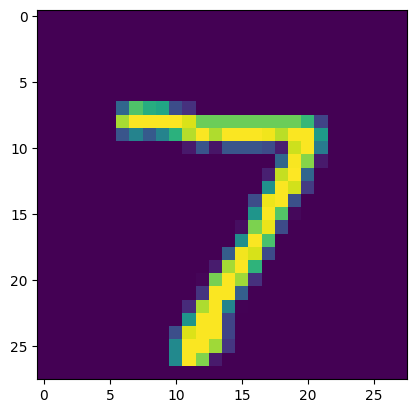

In [13]:
show_image(x, idx=0)

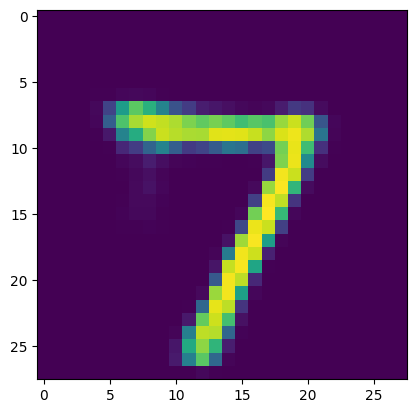

In [15]:
show_image(x_hat, idx=0)

**노이즈 벡터로부터 이미지 생성하기**

In [16]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

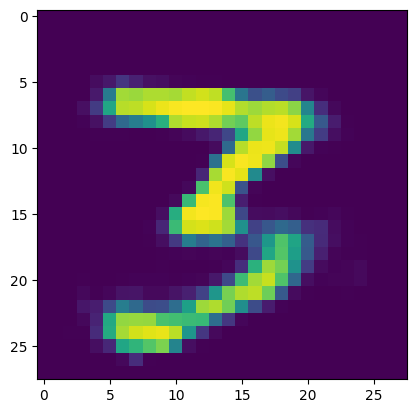

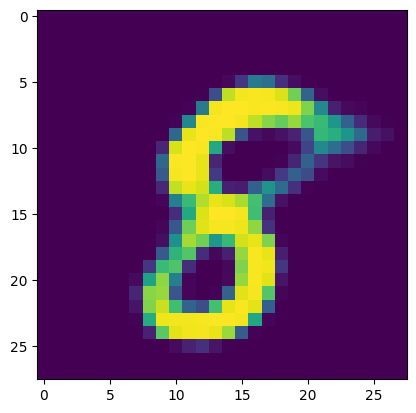

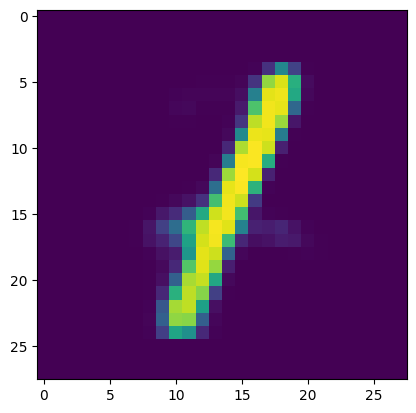

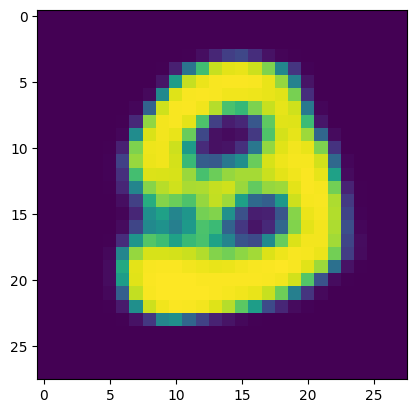

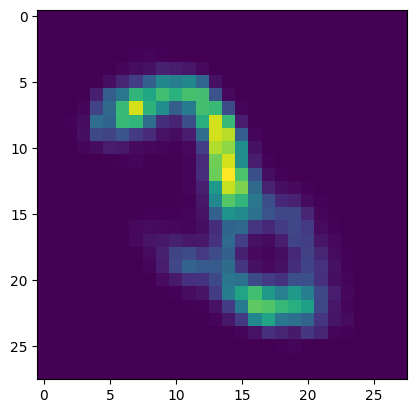

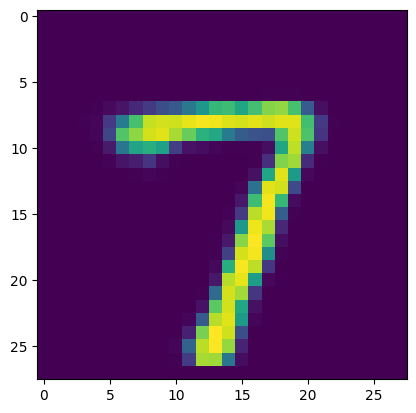

In [17]:
show_image(generated_images, idx=12)
show_image(generated_images, idx=0)
show_image(generated_images, idx=1)
show_image(generated_images, idx=10)
show_image(generated_images, idx=20)
show_image(generated_images, idx=50)